In [2]:
import tensorflow as tf

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import Dataset
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, Concatenate, BatchNormalization, Activation, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
img_width, img_height = 128,128
img_size = img_width, img_height
input_channels = 3
output_channels = 1
input_shape = (img_width, img_height, input_channels)
output_shape = (img_width, img_height, output_channels)
seed = 13
batch_size = 8

train_dir = "train/image/"
train_mask_dir = "train/label/"
val_dir = "val/image/"
val_mask_dir = "val/label/"
test_dir = "test/image/"
test_mask_dir = "test/label/"

In [7]:
def clean_image_dir(dir_name):
  files = os.listdir(dir_name)
  for f in files:
    file_name = os.path.splitext(f)[0]
    extension = os.path.splitext(f)[1]
    if extension == ".tif":
      img = cv2.imread(dir_name+f)
      cv2.imwrite(dir_name+file_name+".jpg", img)
      os.remove(dir_name+f)

def clean_image_mask_dir(dir_name):
  files = os.listdir(dir_name)
  for f in files:
    file_name = os.path.splitext(f)[0]
    extension = os.path.splitext(f)[1]
    if extension == ".tif":
      img = cv2.imread(dir_name+f)
      img = img[:,:,0]+1
      cv2.imwrite(dir_name+file_name+".png", img)
      os.remove(dir_name+f)

In [8]:
clean_image_dir(train_dir)
clean_image_mask_dir(train_mask_dir)

clean_image_dir(val_dir)
clean_image_mask_dir(val_mask_dir)

clean_image_dir(test_dir)
clean_image_mask_dir(test_mask_dir)

Found 4736 files belonging to 1 classes.
Found 4736 files belonging to 1 classes.
Found 1036 files belonging to 1 classes.
Found 1036 files belonging to 1 classes.
Found 2416 files belonging to 1 classes.
Found 2416 files belonging to 1 classes.


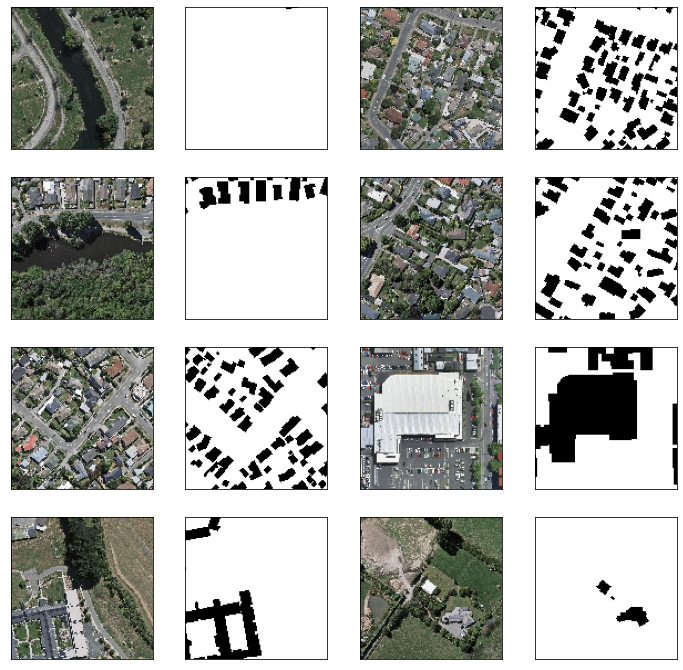

In [9]:
def generate_dataset_from_directory(directory, color_mode="rgb", interpolation="nearest", validation_split=None, subset=None):
  # Generamos el objeto Dataset a partir de un directorio
  ds = image_dataset_from_directory(
      directory,
      labels=None,
      label_mode=None,
      batch_size=batch_size,
      image_size=(img_width, img_height),
      seed=seed,
      interpolation=interpolation,
      color_mode=color_mode,
      validation_split=validation_split,
      subset=subset)
  return ds.prefetch(buffer_size=batch_size)

input_ds_train = generate_dataset_from_directory(train_dir)
mask_ds_train = generate_dataset_from_directory(train_mask_dir, color_mode="grayscale")

input_ds_val = generate_dataset_from_directory(val_dir)
mask_ds_val = generate_dataset_from_directory(val_mask_dir, color_mode="grayscale")

input_ds_test = generate_dataset_from_directory(test_dir)
mask_ds_test = generate_dataset_from_directory(test_mask_dir, color_mode="grayscale")

# En este tipo de problemas tenemos que 'casar' manualmente los datos asignando una máscara a cada una de las imágenes de cada dataset
train_dataset = Dataset.zip((input_ds_train, mask_ds_train))
val_dataset = Dataset.zip((input_ds_val, mask_ds_val))
test_dataset = Dataset.zip((input_ds_test, mask_ds_test))

sample_size = 8
cols = 4
rows = sample_size * 2 // cols
plt.figure(figsize=(cols * 3, rows * 3))

for x_batch, y_batch in train_dataset.take(1):
  for i in range(sample_size):
    plt.subplot(rows, cols, i * 2 + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_batch[i])
    plt.subplot(rows, cols, i * 2 + 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y_batch[i].numpy()[:,:,0], cmap="gray")

### RESNET CON TRANSFER-LEARNING UNET

In [ ]:
from keras_unet.models import satellite_unet

def create_model(num_classes, dropout=False):
    # Función para crear cada uno de los bloques de convolución transpuesta, esto es, la operación contraria a la convolución
    # que trata de reconstruir una imagen. En mi caso lo he diseñado haciendo un 'espejo' de los bloques convolucionales.
    def decoder_block(input, skip_connection, num_filters, dropout=0):
        x = Conv2DTranspose(num_filters, 2, strides=2, padding="same", dtype="float32")(input)
        x = Concatenate()([x, skip_connection])

        x = Conv2D(num_filters, 3, padding="same", dtype="float32")(x)
        x = BatchNormalization(dtype="float32")(x)
        x = Activation("relu")(x)

        x = Conv2D(num_filters, 3, padding="same", dtype="float32")(x)
        x = BatchNormalization(dtype="float32")(x)
        x = Activation("relu")(x)

        if dropout:
            x = Dropout(dropout)(x)

        return x

    # Capa de entrada
    inputs = Input(input_shape)

    # Transfer Learning con Modelo ResNet entrenado sobre ImageNet
    residual = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    #unet = satellite_unet(input_shape=(img_width,img_height, 3))

    # Descongelamos las cuatro últimas capas del modelo preentrenado para modificar sus pesos con nuestros datos,
    # de esta forma lo adaptamos mínimamente a nuestro problema
    residual.trainable = False
    residual.layers[-4].trainable = True

    # Outputs del encoder para conexiones residuales
    s1 = residual.get_layer(index=0).output
    s2 = residual.get_layer("conv1_relu").output
    s3 = residual.get_layer("conv2_block3_out").output
    s4 = residual.get_layer("conv3_block4_out").output

    # Puente
    b1 = residual.get_layer("conv4_block6_out").output

    # Decoder
    d1 = decoder_block(b1, s4, 512, 0.4 if dropout else None)
    d2 = decoder_block(d1, s3, 256, 0.3 if dropout else None)
    d3 = decoder_block(d2, s2, 128, 0.3 if dropout else None)
    d4 = decoder_block(d3, s1, 64, 0.2 if dropout else None)

    # Salida de la red
    outputs = Conv2D(num_classes, 3, padding="same", activation="softmax", dtype="float32")(d4)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

    return model

### UNET DESDE CERO

In [10]:
from tensorflow.keras import layers

def get_model(img_size,num_classes):
    inputs = tf.keras.Input(shape = img_size + (3,))

    ### [Empezamos a montar la red: comenzando downsampling...] ###
    # Ponemos los bloques
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual, los guardamos en una red residual para activarlo mas tarde

    # Blocks 1, 2, 3 are identical apart from the feature depth. (creamos las redes de convolucion)
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        Dropout(0.5)(x)

        # Project residual, hacemos la red residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual (lo guardamos)
        previous_block_activation = x  # Set aside next residual


    ### [Empezamos a montar la red: comenzando upsampling...] ###
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)
        Dropout(0.5)(x)

        # Project residual (cojemos las redes que hemos creados y hacemos el trabajo)
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual (lo guardamos)
        previous_block_activation = x  # Set aside next residual (y lo ponemos mas adelante)

    # (y agregamos la redes de convlocuon por pixel)
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Definimos el modelo
    model = tf.keras.Model(inputs, outputs)
    return model

# Liberamos un poco de ram si lo ejecutamos varias veces
tf.keras.backend.clear_session()

# guardamos el modelo y comprobamos los resultados
model = get_model(img_size, 2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [52]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.

#model = create_model(2, dropout=True)
#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

from keras_unet.models import satellite_unet

model_unet = satellite_unet(input_shape=(img_width,img_height, 3))

model_unet.compile(optimizer="rmsprop", loss="binary_crossentropy",  metrics=[tf.keras.metrics.BinaryAccuracy()])

callbacks = [
             ModelCheckpoint(
                 'checkpoint/unet-{val_loss:03f}-({epoch:02d}).h5',
                 monitor='val_loss',
                 save_best_only=True),
             EarlyStopping(monitor="val_loss", patience=10)
]

history = model_unet.fit(
    train_dataset,
    epochs=100,
    batch_size=batch_size,
    validation_data=val_dataset,
    callbacks=callbacks
    )

Epoch 1/100
592/592 [==============================] - 64s 100ms/step - loss: 0.1879 - binary_accuracy: 0.9240 - val_loss: 0.1036 - val_binary_accuracy: 0.9587
Epoch 2/100
592/592 [==============================] - 59s 99ms/step - loss: 0.1222 - binary_accuracy: 0.9523 - val_loss: 0.0612 - val_binary_accuracy: 0.9769
Epoch 3/100
592/592 [==============================] - 59s 99ms/step - loss: 0.1060 - binary_accuracy: 0.9591 - val_loss: 0.0629 - val_binary_accuracy: 0.9771
Epoch 4/100
592/592 [==============================] - 59s 99ms/step - loss: 0.0965 - binary_accuracy: 0.9626 - val_loss: 0.0658 - val_binary_accuracy: 0.9744
Epoch 5/100
592/592 [==============================] - 59s 99ms/step - loss: 0.0901 - binary_accuracy: 0.9653 - val_loss: 0.0515 - val_binary_accuracy: 0.9804
Epoch 6/100
592/592 [==============================] - 59s 99ms/step - loss: 0.0858 - binary_accuracy: 0.9670 - val_loss: 0.0613 - val_binary_accuracy: 0.9775
Epoch 7/100
592/592 [========================

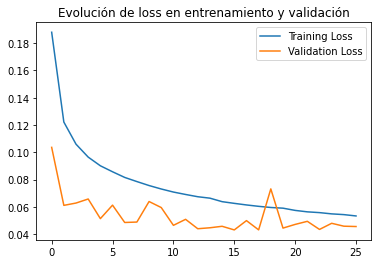

In [53]:
def show_training_graph(data):
  loss = data.history['loss']
  val_loss = data.history['val_loss']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Evolución de loss en entrenamiento y validación')
  plt.legend(loc='upper right')

  plt.show()

show_training_graph(history)

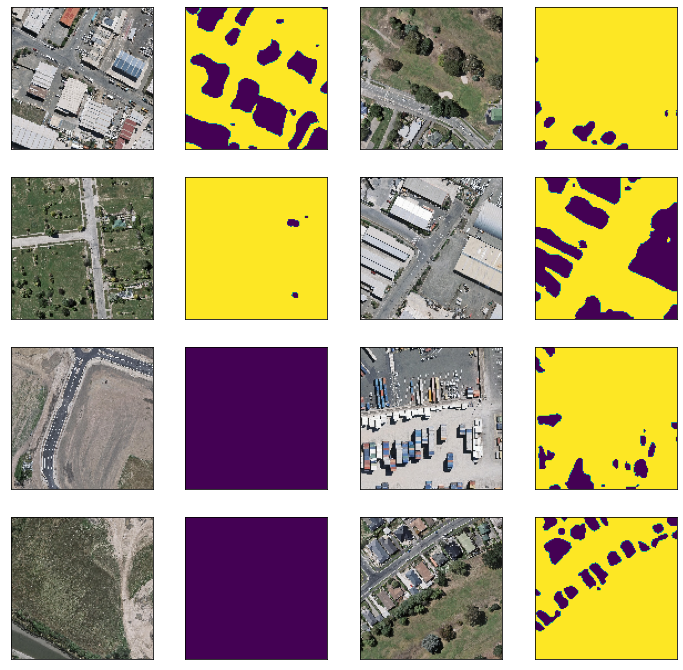

In [54]:
sample_size = 8
cols = 4
rows = sample_size * 2 // cols

plt.figure(figsize=(cols * 3, rows * 3))

for x_batch, y_batch in test_dataset.take(1):
  for i in range(sample_size):
    plt.subplot(rows, cols, i * 2 + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_batch[i])
    plt.subplot(rows, cols, i * 2 + 2)
    plt.xticks([])
    plt.yticks([])
    prediction = model.predict(np.expand_dims(x_batch[i], 0))[0]
    prediction = np.argmax(prediction, axis=-1)
    plt.imshow(prediction)

In [36]:
model.save("ModeloUnet/modelo_tfg_2.h5")

In [37]:
model = load_model("ModeloUnet/modelo_tfg_2.h5")

In [48]:
img = cv2.imread("IMAGENES GOOGLE EARTH/img0001.png")
#img = cv2.imread("test_final.png")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = cv2.resize(img, (128,128))

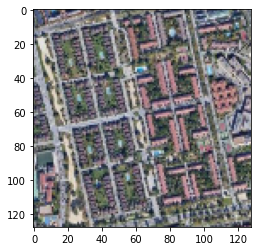

In [49]:
plt.imshow(img)

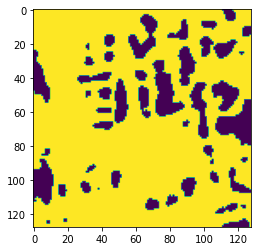

In [50]:
prediction = model.predict(np.expand_dims(img, 0))[0]
prediction = np.argmax(prediction, axis=-1)
#prediction[prediction == 0] = 255
#prediction[prediction == 1] = 0
plt.imshow(prediction)

In [31]:
prediction = np.uint8(prediction)
prediction = cv2.blur(prediction, (3,3))
contours, hierarchy = cv2.findContours(prediction,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

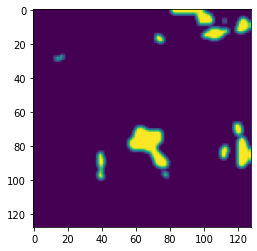

In [32]:
plt.imshow(prediction)

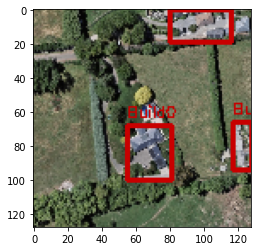

In [33]:
idx = 0
color = [tuple(np.random.choice(range(256), size=3)) for x in range(len(contours))]
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if w > 10 and h > 10:
        roi=img[y:y+h,x:x+w]
        # cv2.rectangle(img,(x,y),(x+w,y+h),(int(color[idx][0]), int(color[idx][1]),int(color[idx][2])),2)
        cv2.rectangle(img,(x,y),(x+w,y+h),(200, 0, 0),2)
        # cv2.putText(img, "Build"+str(idx), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (int(color[idx][0]), int(color[idx][1]),int(color[idx][2])), 1)
        cv2.putText(img, "Build"+str(idx), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(200, 0, 0), 1)
        idx += 1
plt.imshow(img)

In [ ]:
cap = cv2.VideoCapture('test_warcelona.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    frame = cv2.resize(frame, (256,256))
    prediction = model.predict(np.expand_dims(frame, 0))[0]
    prediction = np.argmax(prediction, axis=-1)
    prediction[prediction == 0] = 255
    prediction[prediction == 1] = 0
    prediction = np.uint8(prediction)
    prediction = cv2.blur(prediction, (3,3))
    contours, hierarchy = cv2.findContours(prediction,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    idx = 0
    color = [tuple(np.random.choice(range(256), size=3)) for x in range(len(contours))]
    for cnt in contours:
      x,y,w,h = cv2.boundingRect(cnt)
      if w > 10 and h > 10:
        roi=frame[y:y+h,x:x+w]
        # cv2.rectangle(img,(x,y),(x+w,y+h),(int(color[idx][0]), int(color[idx][1]),int(color[idx][2])),2)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0, 0, 200),2)
        # cv2.putText(img, "Build"+str(idx), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (int(color[idx][0]), int(color[idx][1]),int(color[idx][2])), 1)
        cv2.putText(frame, "Building"+str(idx), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(200, 0, 0), 1)
        idx += 1
    frame = cv2.resize(frame, (1080,720))
    prediction = cv2.cvtColor(prediction,cv2.COLOR_GRAY2RGB)
    prediction = cv2.resize(prediction, (1080,720))
    numpy_horizontal_concat = np.concatenate((frame, prediction), axis=1)

    cv2.imshow('frame', numpy_horizontal_concat)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()